#### Imports

In [1]:
import PyPDF2
import csv
import re
import json
import os
import us
import numpy as np

# OCR with Adobe Acrobat and extraction with fitz

In [2]:
from __future__ import print_function
from itertools import groupby
import fitz
import matplotlib.pyplot as plt

- Functions for reading text from PDF

In [3]:
def find_edges(x0s):
    '''
    Find the coordinates of boxes that seperates the columns in the PDF file.
    '''
    # only one row of data (p86, p143)
    if max(x0s) < 200: 
        return (None, None) 
    
    # 2 rows of data (p146, p218)
    # the one before zero and the one after zero has a difference greater than 20, 
    if max(x0s) < 400: 
        counts, xedges, _ = plt.hist(x0s, bins = 40)
        i = 8
        while i < 30:
            if (counts[i] == 0) and (counts[i + 1] -  counts[i - 1] > 20) and (xedges[i] > 160) and (xedges[i] < 220):
                return (xedges[i], None)
            i += 1
        if i == 30:
            i = 8
            while i < 30:
                if (counts[i + 1] -  counts[i] > 20) and (xedges[i] > 160) and (xedges[i] < 220):
                    return (xedges[i], None)
                i += 1
        if i == 30:
            i = 8
            while i < 30:
                if (counts[i] == 0) and (counts[i + 1] == 0) and (xedges[i] > 160) and (xedges[i] < 220):
                    return (xedges[i], None)
                i += 1
    # 3 rows of data
    counts, xedges, _ = plt.hist(x0s, bins = 100)
    # line between col 1 & 2            
    i = 20
    while i < 45:
        if (counts[i] == 0) and (counts[i + 1] - counts[i - 1] > 20) and (xedges[i] > 160) and (xedges[i] < 220):
            xcol1 = xedges[i]
            break
        i += 1
    if i == 45:
        i = 20
        while i < 45:
            if (counts[i + 1] - counts[i] > 20) and (xedges[i] > 160) and (xedges[i] < 220):
                xcol1 = xedges[i]
                break
            i += 1
    if i == 45:
        i = 20
        while i < 45:
            if (counts[i] == 0) and (counts[i + 1] == 0) and (xedges[i] > 160) and (xedges[i] < 220):
                xcol1 = xedges[i + 1]
                break
            i += 1
            
    # line between col 2 & 3
    while i < 80:
        if (counts[i] == 0) and (counts[i + 1] - counts[i - 1] > 20) and (xedges[i] > 330) and (xedges[i] < 390):
            xcol2 = xedges[i]
            break
        i += 1
    if i == 80:
        i = 50
        while i < 80:
            if (counts[i] - counts[i - 1] > 20) and (xedges[i] > 330) and (xedges[i] < 390):
                xcol2 = xedges[i + 1]
                break
            i += 1
    if i == 80:
        i = 50
        while i < 80:
            if (counts[i] == 0) and (counts[i + 1] == 0) and (xedges[i] > 330) and (xedges[i] < 390):
                xcol2 = xedges[i + 1]
                break
            i += 1
    return (xcol1, xcol2)

In [4]:
def get_words_in_box(page):
    '''
    Extract words from each column of the PDF.
    '''
    #print(page)
    x, y = page.MediaBox[2:] #size of page
    words = page.getText("words") #each word with extracted coordinate\
    #cut off top word if exist
    y0s = [word[1] for word in words]
    if sum(y0 < (min(y0s)+10) for y0 in y0s) < 3:
        words = [word for word in words if word[1] > (min(y0s)+10)]
    #cut off bottom
    words = [word for word in words if word[1] < (max(y0s)-10)]
    #find col 1 and 2
    x0s = [word[0] for word in words]
    xcol1, xcol2 = find_edges(x0s)
    page_txt = []
    if xcol1 == None:
        page_txt.append(words)
        return page_txt
    if xcol2 == None:
        page_txt.append([word for word in words if word[0] < xcol1])
        page_txt.append([word for word in words if word[0] > xcol1])
        return page_txt
    page_txt.append([word for word in words if word[0] < xcol1])
    page_txt.append([word for word in words if ((word[0] > xcol1) and (word[0] < xcol2))])
    page_txt.append([word for word in words if word[0] > xcol2])
    return page_txt

- Extract text

In [5]:
#open PDF which has gone through Adobe Acrobat OCR
doc = fitz.open("directory_1980_drug.pdf")
len(doc)

172

In [13]:
page = doc[18]

In [14]:
words = page.getText("words")

(array([57.,  1.,  2., 19., 13.,  1.,  9., 12., 15.,  6.,  4., 12.,  3.,
         2.,  7.,  9.,  1.,  3.,  1.,  1.,  0.,  1.,  2.,  1.,  0.,  0.,
         0.,  0., 56.,  1.,  0.,  5., 24.,  1.,  5.,  9., 15., 14.,  4.,
        16.,  1.,  2.,  9., 10.,  4.,  1.,  2.,  2.,  0.,  2.,  1.,  2.,
         0.,  0.,  0.,  0.,  0., 58.,  0.,  5., 12.,  9.,  6.,  7., 16.,
         5.,  6., 11.,  6.,  5.,  1.,  3., 12.,  1.,  2.,  0.,  0.,  3.,
         0.,  5.]),
 array([ 27.36000061,  33.75000057,  40.14000053,  46.5300005 ,
         52.92000046,  59.31000042,  65.70000038,  72.09000034,
         78.48000031,  84.87000027,  91.26000023,  97.65000019,
        104.04000015, 110.43000011, 116.82000008, 123.21000004,
        129.6       , 135.98999996, 142.37999992, 148.76999989,
        155.15999985, 161.54999981, 167.93999977, 174.32999973,
        180.71999969, 187.10999966, 193.49999962, 199.88999958,
        206.27999954, 212.6699995 , 219.05999947, 225.44999943,
        231.83999939, 238.2299

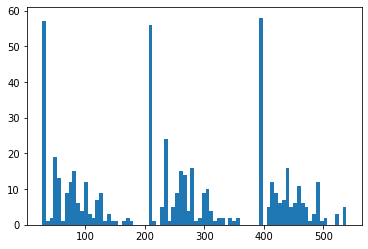

In [17]:
x0s = [word[0] for word in words]
plt.hist(x0s, bins = 80)

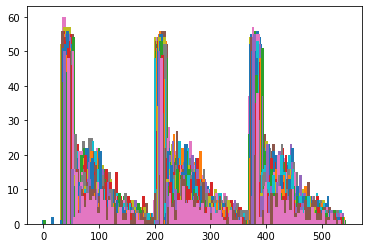

In [58]:
#get data
data = []
for pagen in range(12, 562):
    data.append(get_words_in_box(doc[pagen-1]))

# Write data into csv

In [59]:
abbr_keys = ["TX", "ML", "PV", "OS", "DT",\
             "OD", "OR", "IO", "ID", "IR", "RD", "RR",\
             "AD", "DD", "HV", "PW",\
             "SS", "GH", "PH", "OH", "TC", "HH", "CM", "CH", \
             "CO", "SG", "SC", "CJ",\
             "MC", "MD", "FG", "PI"]

In [204]:
def col_text_to_rows(col_text):
    '''
    Splits text into rows
    '''
    col_text_by_row = []
    temp = []
    init_y = col_text[0][1] #y0
    i = 0
    while i < len(col_text):
        if (col_text[i][1] < init_y + 3) and (col_text[i][1] > init_y - 3):
            temp.append(col_text[i][4])
        else:
            col_text_by_row.append(temp)
            temp = [col_text[i][4]]
            init_y = int(col_text[i][1])
        i += 1
    col_text_by_row.append(temp)
    return col_text_by_row

#runs the function on all data
def all_text_to_rows(data):
    all_text = []
    for page_text in data:
        page_text_by_row = []
        for col_text in page_text:
            page_text_by_row.append(col_text_to_rows(col_text))
        all_text.append(page_text_by_row)
    return all_text

In [205]:
all_text = all_text_to_rows(data)

- Writing text to .csv

In [206]:
def is_keys(line):
    if line[0][:2].replace('Y', 'V').replace('1', 'I').replace('0', 'O') in abbr_keys:
        if len(line) == 1:
            return True
        elif line[1][:2].replace('Y', 'V').replace('1', 'I').replace('0', 'O') in abbr_keys:
            return True
    return False

In [207]:
def split_col_data(col_text):
    '''
    Split column data into list of MOUD facilities.
    '''
    col_text_splitted = []
    temp = []
    i = 0
    while i < len(col_text) - 1:
        if is_keys(col_text[i]) and (not is_keys(col_text[i+1])):
            temp.append(col_text[i])
            col_text_splitted.append(temp)
            temp = []
        else:
            if not ''.join(col_text[i]).isupper(): #not the capitalized city name which should be ignored
                temp.append(col_text[i])
        i += 1
    temp.append(col_text[-1])
    col_text_splitted.append(temp)
    return col_text_splitted

In [208]:
address_indicators = ['Box', 'P.0.Box', 'Road', 'Highway', 'Route', 'Building', 'Street', 'Avenue', 'Suite', 'Drive', 'Boulevard']

In [209]:
def clean_key(key):
    return key.replace('Y', 'V').replace('1', 'I').replace('0', 'O')

In [217]:
def clean_col_data(col_text_splitted):
    '''
    Splits data into list of lists with
    name1, name2, address1, address2, city, state, zip, phone, keys
    '''
    data_holders = []
    for facil in col_text_splitted:
        data_holder = []
        i = 0 #indicator of next line
        #name1
        data_holder.append(' '.join(facil[0])) 
        i += 1
        #name2
        if (not facil[i][0].isnumeric()) and (not any(x in facil[i] for x in address_indicators)):
            data_holder.append(' '.join(facil[i])) 
            i += 1
        else:
            data_holder.append('') 
        #address1
        data_holder.append(' '.join(facil[i])) 
        i += 1
        #address2
        if facil[i][0].isnumeric() or any(x in facil[i] for x in address_indicators):
            data_holder.append(' '.join(facil[i])) 
            i += 1
        else:
            data_holder.append('') 
        #city, state, zip
        data_holder.append(' '.join(facil[i][0:-2])[:-1]) 
        data_holder.append(facil[i][-2]) 
        data_holder.append(facil[i][-1]) 
        i += 1
        #contact
        data_holder.append(''.join(facil[i]))
        i += 1
        while i < len(facil):
            if not is_keys(facil[i]):
                data_holder[-1] += ' ' + ''.join(facil[i])
                i += 1
            else:
                break
        #keys
        data_holder.append('')
        for keys in facil[i:]:
            for key in keys:
                if len(key) == 2:
                    data_holder[-1] += clean_key(key) + '/'
                elif len(key) == 3:
                    data_holder[-1] += clean_key(key[:2]) + '/'
                else:
                    for key in key.split('/'):
                        if len(key) == 2:
                            data_holder[-1] += clean_key(key) + '/'
                        else:
                            data_holder[-1] += '/'.join([clean_key(key[i:i+2]) for i in range(0, len(key), 2)])
        data_holders.append(data_holder)
    return data_holders

In [218]:
with open(filename, 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(["Name1", "Name2", "Address1", "Address2", "City", "State", "ZIP_Code", "Contact", "Keys"])

In [219]:
filename = "1998.csv"
pagen = 12

for page in all_text[:2]:
    print("Page:", pagen)
    page_data_holders = []
    for col in page:
        col_text_splitted = split_col_data(col)
        page_data_holders += clean_col_data(col_text_splitted)
    with open(filename, 'a', newline = '') as file:
        writer = csv.writer(file)
        writer.writerows(page_data_holders)
    pagen += 1

Page: 12
Page: 13


In [56]:
errorpagen = 164 #33, 111, 126, 143, 164

# OCR with tesserocr
- Not used in the end because of low accuracy and slow...
- https://github.com/sirfz/tesserocr
- https://www.geeksforgeeks.org/python-reading-contents-of-pdf-using-ocr-optical-character-recognition/
- https://pypi.org/project/tesserocr/

- Testing tesserocr

In [3]:
from tesserocr import PyTessBaseAPI, RIL
from pdf2image import convert_from_path 
import pytesseract
from PIL import Image 

In [4]:
import matplotlib.pyplot as plt

In [5]:
PDF_file = "1998/directory_1998.pdf"

In [6]:
# Store all the pages of the PDF in a variable 
pages = convert_from_path(PDF_file, dpi = 500, grayscale=True) 

In [7]:
def find_box(imgarr):
    '''
    Returns a list of three boxes for image recognition
    '''
    #row bottom
    nrow, ncol = imgarr.shape
    boxes = [[0]*4 for _ in range(3)]
    i = 4800
    while (imgarr[i:i+80, 10:ncol-10].min() != 255):
        i += 1
    i += 10
    for box in boxes:
        box[3] = i
    #col 1
    j = 1200
    while (imgarr[50:i, j:j+30].min() != 255):
        j += 1
    j += 10
    boxes[0][2] = j
    boxes[1][0] = j
    #col 2
    k = j + 1000
    while (imgarr[50:i, k:k+30].min() != 255):
        k += 1
    boxes[1][2] = k + 10 - j
    boxes[2][0] = k + 10
    #col 3
    boxes[2][2] = ncol - (k + 10)
    return boxes

In [205]:
page = np.array(pages[12 - 1])
pages[12 - 1].save("1998/page.jpeg", 'JPEG')

In [219]:
find_box(np.array(pages[12 - 1]))

[[0, 0, 1351, 4858], [1351, 0, 1232, 4858], [2583, 0, 1511, 4858]]

In [ ]:
i = 1
data = []
for i in range(196, 562): # i is the page number in PDF
    print("Page", i)
    boxes = find_box(np.array(pages[i - 1]))
    pages[i - 1].save("1998/page.jpeg", 'JPEG') 
    with PyTessBaseAPI() as api:
        api.SetImageFile("1998/page.jpeg")
        txt = ''
        for box in boxes:
            api.SetRectangle(box[0], box[1], box[2], box[3])
            ocrResult = api.GetUTF8Text()
            txt += ocrResult
        data.append(txt)
        with open('1998/rawdata.txt', 'a') as f:
            f.write("%s\n\n\n\n\n\n\n\n" % txt)

Page 12
Page 13
Page 14
Page 15
Page 16
Page 17
Page 18
Page 19
Page 20
Page 21
Page 22
Page 23
Page 24
Page 25
Page 26
Page 27
Page 28
Page 29
Page 30
Page 31
Page 32
Page 33
Page 34
Page 35
Page 36
Page 37
Page 38
Page 39
Page 40
Page 41
Page 42
Page 43
Page 44
Page 45
Page 46
Page 47
Page 48
Page 49
Page 50
Page 51
Page 52
Page 53
Page 54
Page 55
Page 56
Page 57
Page 58
Page 59
Page 60
Page 61
Page 62
Page 63
Page 64
Page 65
Page 66
Page 67
Page 68
Page 69
Page 70
Page 71
Page 72
Page 73
Page 74
Page 75
Page 76
Page 77
Page 78
Page 79
Page 80
Page 81
Page 82
Page 83
Page 84
Page 85
Page 86
Page 87
Page 88
Page 89
Page 90
Page 91
Page 92
Page 93
Page 94
Page 95
Page 96
Page 97
Page 98
Page 99
Page 100
Page 101
Page 102
Page 103
Page 104
Page 105
Page 106
Page 107
Page 108
Page 109
Page 110
Page 111
Page 112
Page 113
Page 114
Page 115
Page 116
Page 117
Page 118
Page 119
Page 120
Page 121
Page 122
Page 123
Page 124
Page 125
Page 126
Page 127
Page 128
Page 129
Page 130
Page 131
Page 132

In [8]:
#save the data just because
with open('1998/rawdata.txt', 'w') as f:
    for item in data:
        f.write("%s\n\n\n" % item)

# Write data into csv

In [57]:
#clean_data(data[errorpagen-12])

In [58]:
data[errorpagen-12].replace('\n\n', '\n').split('\n')

['McDonough District Hospital',
 'Recovery Center',
 '525 East Grant Street',
 'MaComb, IL 61455',
 '(309)833—4101 x 3270',
 'Hotline:',
 '(309)833—4101',
 'TX PV OS/ OR 10/ AD DD/ 01-] CM CO/',
 'P1',
 '1‘',
 'MANTENO',
 'S',
 'Kankakee Minimum Security Unit 3',
 '37040 South Illinois Street 11',
 'Route 102 (‘',
 'Manteno, IL 60950 P',
 '(815 )476—5201 (‘',
 "TX 03/ 10/ 88 CJ '1",
 "Riverside Resolve Center '1",
 '41 1 Division Street 1',
 'Manteno, IL 60950 1\\',
 '(815)468-3241 (‘',
 "TX PV OS DT/ OR 10 1D 1R RD RR/ AD '1",
 'HV PW/ SS TC/ MC MD P1',
 "'1",
 'Substance Abuse Services Inc 2',
 'Branden House 1\\',
 "800 Bramble Street ('",
 "Manteno, IL 60950 '1",
 '(815)468-6556',
 'TX MU RR/ SS TC 1‘',
 'MARSHALL F',
 '1\\',
 'Human Resources Center of 5',
 'Edgar and Clark Counties h',
 '1006 South 6th Street (1',
 'Marshall, IL 62441 1',
 '(217)465-41 18 (:',
 "Hotline: '1",
 '(217)465-4141',
 'TX 08/ OR/ AD/ CM 1\\',
 '5',
 'MARYVILLE S',
 '1\\',
 'Chestnut Health Systems Inc (

In [59]:
data[errorpagen-12]

"McDonough District Hospital\n\nRecovery Center\n\n525 East Grant Street\n\nMaComb, IL 61455\n\n(309)833—4101 x 3270\n\nHotline:\n\n(309)833—4101\n\nTX PV OS/ OR 10/ AD DD/ 01-] CM CO/\nP1\n\n1‘\nMANTENO\n\nS\nKankakee Minimum Security Unit 3\n37040 South Illinois Street 11\nRoute 102 (‘\nManteno, IL 60950 P\n(815 )476—5201 (‘\nTX 03/ 10/ 88 CJ '1\nRiverside Resolve Center '1\n41 1 Division Street 1\nManteno, IL 60950 1\\\n(815)468-3241 (‘\nTX PV OS DT/ OR 10 1D 1R RD RR/ AD '1\nHV PW/ SS TC/ MC MD P1\n\n'1\nSubstance Abuse Services Inc 2\nBranden House 1\\\n800 Bramble Street ('\nManteno, IL 60950 '1\n(815)468-6556\nTX MU RR/ SS TC 1‘\nMARSHALL F\n\n1\\\nHuman Resources Center of 5\nEdgar and Clark Counties h\n1006 South 6th Street (1\nMarshall, IL 62441 1\n(217)465-41 18 (:\nHotline: '1\n(217)465-4141\nTX 08/ OR/ AD/ CM 1\\\n\n5\nMARYVILLE S\n\n1\\\nChestnut Health Systems Inc (1\n2148 Vadalabene Road 1\nMaryville, IL 62062\n(618)288-3100 1‘\nTX PV OS/ OR RR/ AD DD/ SS\n\nP\nMATTOON 

data[errorpagen-12] = "McDonough District Hospital\n\nRecovery Center\n\n525 East Grant Street\n\nMaComb, IL 61455\n\n(309)833—4101 x 3270\n\nHotline:\n\n(309)833—4101\n\nTX PV OS/ OR 10/ AD DD/ GH CM CO/\nP1\n\nMANTENO\n\nS\nKankakee Minimum Security Unit 3\n37040 South Illinois Street 11\nRoute 102 \nManteno, IL 60950 \n(815 )476—5201 \nTX OS/ IO/ SS CJ \nRiverside Resolve Center \n411 Division Street \nManteno, IL 60950 \n(815)468-3241 \nTX PV OS DT/ OR IO ID 1R RD RR/ AD \nHV PW/ SS TC/ MC MD P1\n\n\nSubstance Abuse Services Inc\nBranden House \n800 Bramble Street \nManteno, IL 60950 \n(815)468-6556\nTX MU RR/ SS TC \nMARSHALL F\n\n1\\\nHuman Resources Center of 5\nEdgar and Clark Counties h\n1006 South 6th Street \nMarshall, IL 62441\n(217)465-4118 \nHotline: \n(217)465-4141\nTX 08/ OR/ AD/ CM \nMARYVILLE S\n\nChestnut Health Systems Inc (1\n2148 Vadalabene Road 1\nMaryville, IL 62062\n(618)288-3100 \nTX PV OS/ OR RR/ AD DD/ SS\n\nP\nMATTOON F\n\nCentral East Alcohol and Drug Council\nAdolescent Outpatient Services \n513 North 13th Street ?\nMattoon, IL 61938\n(217)348-8108 T\n\nHotline:\n(217)348-8108\nTX 03/ OR/ AD/ SS\n\nZentral East Alcohol and Drug Council\n)utpatient Services\n\nH6 North 19th Street\n\nAattoon, IL 61938\n\n(217)348-8108\n\nlotline:\n\n(217)348-8108\n\n.‘X 08/ OR/ SS\n\nVIAYWOOD\n\niubstance Abuse Operations\n\n.08 South 5th Avenue\n\nMaywood, IL 60153\n\n(708)343-1275\n\n1otline:\n\n(708)343—1275 .\n‘X ML OS/ OR/ HV PW/ 83/ MD FG\n\n‘he Way Back Inn Inc\n\n04 Oak Street\n\nMaywood, IL 60153\n(708)345-8422\n\n‘X OS/ OR/ DD/ 1111/ FG\n\n‘he Way Back Inn Inc\n\n.01 South 2nd Avenue\n\nIlaywood, IL 60153-1676\n\n708)345-8422\n\nTX PV OS/ OR RR/ DD/ SS TC HH/ FG PI\n\nVICHENRY\n\n*amily Service and Comm MH Center for\nchenry County\n\n320 West Elm Street\n\nMcHenry, IL 60050\n\n(815)385—6400\n\nHotlinE:\n\n(815)385-6400\n\nTX PV OS/ OR 10/ AD DD/ CM/ MD\n\nMichael L Klestinski and Associates PC\n400 West Elm Street\n\nmm 200\n\n’chenry, IL 60050\n\n315)344—6900\n\n‘X PV 05/ OR 10/ SS SG/ P1\n\nAELROSE PARK\n\n’rocare Centers\n\n:ecovery Center\n\n414 West Mam Street\n\ndelrosc Park, IL 60160\n708)681-0073\n\nlolline:\n\n708)681-4657\n\n'X 08/ OR 10/ DD PW/ SS CM\n\nzaazaz=mg\n\nZN-<\n\n4’3\n\nHSZKUZ 2\n\nHSESZRZ Z\n\nZ\n\nWestlake Community Hospital\nSubstance Recovery Center\n\n1225 Lake Street\n\nMelrose Park, IL 60160\n\n(708)938-7566 x 3561\n\nHotlinc:\n\n(888)333-0966\n\nTX PV OS DT/ OR 10 1D/ DD/ 011/ MC\nMD P1\n\nYos/North Avenue\n\n2140 West North Avenue\nMelrose Park, IL 60160\n(708)343-6060\n\nTX PV OS/ OR] AD/ SS\n\nMENDOTA\n\nMendota Community Hospital\nDUI/Outpatient Services\n\n1315 Memorial Drive\nMendota, 11.. 61342\n(815)539-7461 x 412\n\nTX PV 08/ OR/ SS GH/ P1\n\nMETROPOLIS\n\nMASSAC County Mental Health\n\n206 West 5th Street\n\nMetropolis, IL 62960\n\n(618)524-9368 x 38\n\nHotline:\n\n(6 l 8)524—9368\n\nTX PV OS/ ORl AD DD/ SS CM/ MD P1\n\nMONMOUTH\n\nBridgeway Adapt Services\n219 Euclid Street\nMonmouth, IL 61462\n(309)734-9461\n\nTX PV OS/ OR/ ADI CM\n\nMONTICELLO\n\nPiatt County Mental Health Center\n\n1921 North Market Street\n\nMonticello, IL 61856\n\n(217)762-5371\n\nHotline:\n\n(217)762-4357\n\nTX PV OS/ OR/ AD DD/ SS CM/ MD PI\n\nMORRIS\n\nGrundy County Health Department\n1320 Union Street\n\nMorris. IL 60450-2426\n(815)941-3138\n\nTX OS/ OR/ CM/ P1\n\n"

In [34]:
#save the data just because
with open('1998/rawdata.txt', 'w') as f:
    for item in data:
        f.write("%s\n\n\n\n\n\n" % item)